In [6]:
import os

# Remove incompatible cuDNN versions from LD_LIBRARY_PATH
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ['LD_LIBRARY_PATH']


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.distributions import Categorical

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [4]:
# Data I/O
data = open('input.txt', 'r').read()  # This should be a simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print(f'data has {data_size} characters, {vocab_size} unique.')
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

# Hyperparameters
hidden_size = 100  # Size of hidden layer of neurons
seq_len = 25  # Number of steps to unroll the RNN for
learning_rate = 5e-3
epochs = 20
save_path = 'model.pth'
op_seq_len = 200  # Length of the output sequence
num_layers = 3

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data has 1115394 characters, 65 unique.


In [7]:
class ResidualLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(ResidualLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)  # Change embedding size to match hidden size
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_state):
        embedding = self.embedding(input_seq)
        residual = embedding.clone()  # Use clone to avoid in-place operations
        output, hidden_state = self.lstm(embedding, hidden_state)
        output = output + residual  # Add residual connection
        output = self.decoder(output)
        return output, hidden_state

    def initHidden(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size).to(device),
                torch.zeros(self.num_layers, 1, self.hidden_size).to(device))

# Instantiate model, loss function and optimizer
rnn = ResidualLSTM(vocab_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

In [8]:
# Convert a sequence of characters to a tensor
def char_tensor(seq):
    tensor = torch.tensor([char_to_ix[ch] for ch in seq], dtype=torch.long).unsqueeze(0).to(device)
    return tensor

In [9]:
losses = []
epochs_cnt = []

# Training loop
for i_epoch in range(1, epochs + 1):
    # Random starting point (1st 100 chars) from data to begin
    data_ptr = np.random.randint(100)
    n = 0
    running_loss = 0
    hidden_state = rnn.initHidden()

    while True:
        input_seq = char_tensor(data[data_ptr : data_ptr + seq_len])
        target_seq = char_tensor(data[data_ptr + 1 : data_ptr + seq_len + 1])

        # Forward pass
        output, hidden_state = rnn(input_seq, hidden_state)
        output = output.view(-1, vocab_size)
        target_seq = target_seq.view(-1)

        # Compute loss
        loss = criterion(output, target_seq)
        running_loss += loss.item()

        # Compute gradients and take optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Detach hidden state to prevent backprop through entire training history
        hidden_state = (hidden_state[0].detach(), hidden_state[1].detach())

        # Update the data pointer
        data_ptr += seq_len
        n += 1

        # If at end of data, break
        if data_ptr + seq_len + 1 > data_size:
            break

    # Print loss and save weights after every epoch
    print("Epoch: {0} \t Loss: {1:.8f}".format(i_epoch, running_loss / n))
    epochs_cnt.append(i_epoch)
    losses.append(running_loss / n)
    torch.save(rnn.state_dict(), save_path)

    # Sample / generate a text sequence after every epoch
    data_ptr = 0
    hidden_state = rnn.initHidden()

    # Random character from data to begin
    rand_index = np.random.randint(data_size - 1)
    input_seq = char_tensor(data[rand_index : rand_index + 1])

    print("----------------------------------------")
    while True:
        # Forward pass
        output, hidden_state = rnn(input_seq, hidden_state)

        # Construct categorical distribution and sample a character
        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample()

        # Print the sampled character
        print(ix_to_char[index.item()], end='')

        # Next input is current output
        input_seq = char_tensor(ix_to_char[index.item()])
        data_ptr += 1

        if data_ptr > op_seq_len:
            break

    print("\n----------------------------------------")



Epoch: 1 	 Loss: 1.78565432
----------------------------------------
pst all,
I dost mige: I then own intather in eectingist' yious I speakst
They no what
Angurem'st, beinges up wausst
And nature; all they sorn
Cade in mera is
odless meavyon.

SEBASTIAN:
Whellows. Whoy 
----------------------------------------
Epoch: 2 	 Loss: 1.73713932
----------------------------------------
ele; peepomgs may wat liking. I agson but spore not hidopst in be our shakle with you, se, me me dim gry, as kis knoinale.

GONZALO:
What that be: not nide: set Twalle sea,
We
hath witht sings:
Whimess
----------------------------------------
Epoch: 3 	 Loss: 1.73793900
----------------------------------------
Ad I theis is he non you it shratrt weaks with Thy sauben go, 'Ay well
 SEBANSEBANT:
Itiqul. Yeforieghodved,
I amold andowh roy? whing of thy lovisies upon eoCate should naturion, camatinan? what sir? 
----------------------------------------
Epoch: 4 	 Loss: 1.74974656
------------------------------------

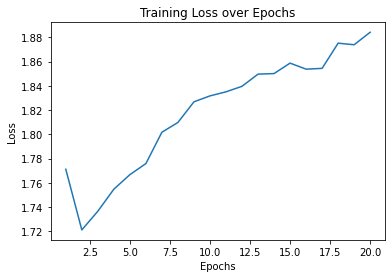

In [13]:
from matplotlib import pyplot as plt
plt.plot(epochs_cnt, losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()